In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

ticker = 'AAPL'
data = yf.download(ticker, start='2010-01-01', end='2023-01-01')

[*********************100%%**********************]  1 of 1 completed


In [2]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.461978,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.473150,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.370186,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.358408,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.400681,447610800


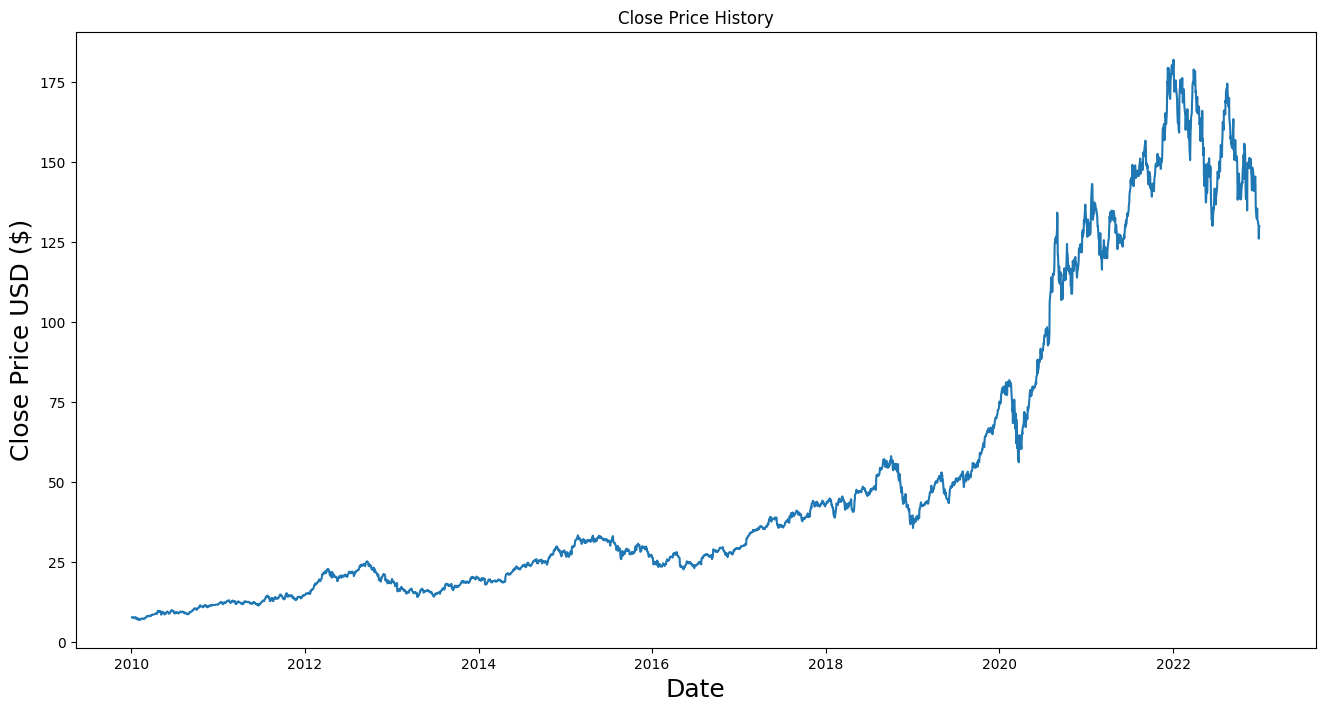

In [3]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(data['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [4]:

df = data.filter(['Close'])
dataset = df.values
training_data_len = int(np.ceil( len(dataset) * .95 ))

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [5]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=1, epochs=1)

3049/3049 [==============================] - 105s 33ms/step - loss: 0.0014


In [6]:
test_data = scaled_data[training_data_len - 60:, :]

x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions

6/6 [==============================] - 1s 14ms/step


<ipython-input-6-5658de28427c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


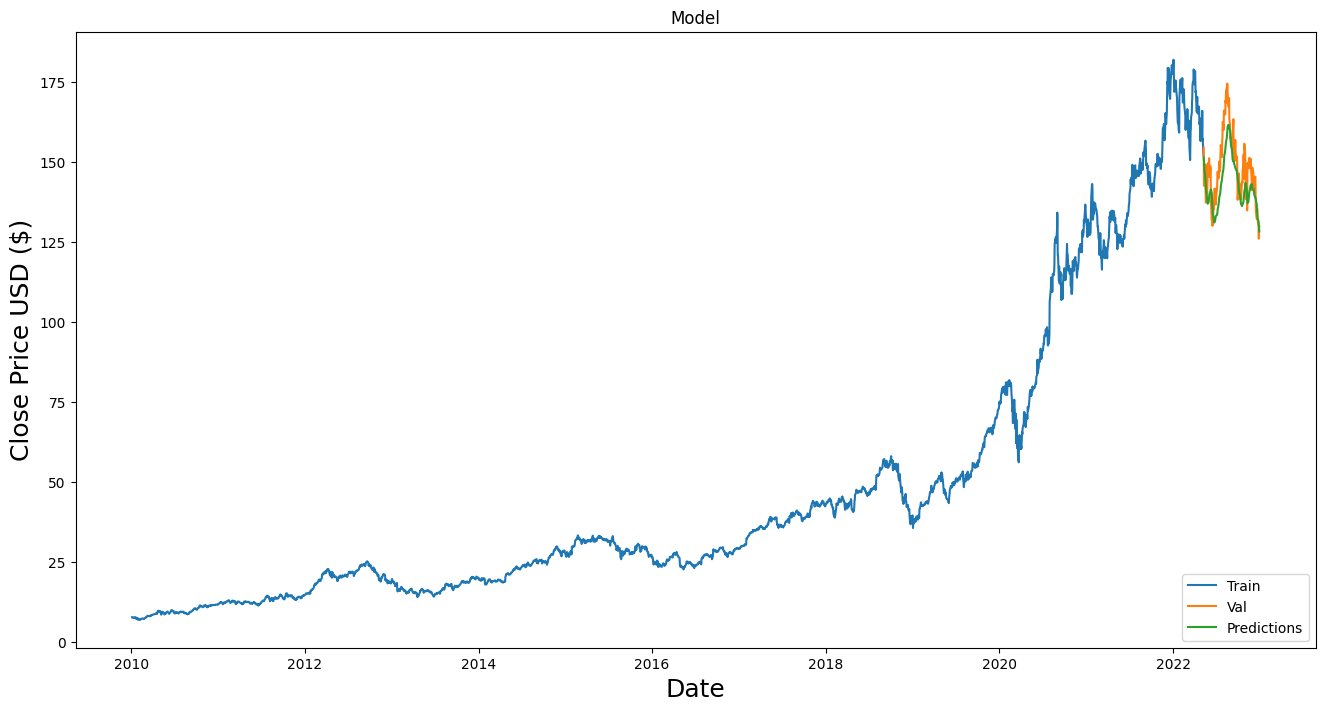

In [7]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [8]:
valid

,Close,Predictions
Date,,
2022-05-10,154.509995,151.421738
2022-05-11,146.500000,150.681458
2022-05-12,142.559998,149.358521
2022-05-13,147.110001,147.581192
2022-05-16,145.539993,146.107071
...,...,...
2022-12-23,131.860001,132.310562
2022-12-27,130.029999,131.380371
2022-12-28,126.040001,130.422211
